In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.div import UnaryDiv
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
import math
import numpy as np
import seaborn as sns

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(mode="unipolar", 
         depth_abs=4, 
         depth_kernel=4, 
         depth_sync=2, 
         shiftreg=False, 
         rng="Sobol", 
         rng_dim=4, 
         bitwidth=8, 
         total_cnt=100, 
         savepdf=False):
    
    stype = torch.float
    btype = torch.float
    rtype = torch.float

    print("========================================================")
    print(mode)
    print("========================================================")
    if mode is "unipolar":
        # all values in unipolar are non-negative
        # dividend is always non greater than divisor
        # divisor is non-zero
        low_bound = 0
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        # values in bipolar are arbitrarily positive or negative
        # abs of dividend is always non greater than abs of divisor
        # abs of divisor is non-zero
        low_bound = -2**(bitwidth-1)
        up_bound = 2**(bitwidth-1)

    divisor_list = []
    dividend_list = []
    for divisor_val in range(up_bound, low_bound-1, -1):
        divisor_list.append([])
        dividend_list.append([])
        for dividend_val in range(low_bound, up_bound+1, 1):
            divisor_list[up_bound-divisor_val].append(divisor_val)
            dividend_list[up_bound-divisor_val].append(dividend_val)
    
    dividend = torch.tensor(dividend_list).type(torch.float).div(up_bound).to(device)
    divisor = torch.tensor(divisor_list).type(torch.float).div(up_bound).to(device)
    quotient = dividend.div(divisor)
    
    # find the invalid postions in quotient
    quotient_nan = torch.isnan(quotient)
    quotient_inf = torch.isinf(quotient)
    quotient_mask = quotient_nan + quotient_inf
    quotient[quotient_mask] = 0
    quotient = quotient.clamp(-1, 1)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        quotientPE = ProgressiveError(quotient, mode=mode).to(device)
    
        dividendPE = ProgressiveError(dividend, mode=mode).to(device)
        dividendSRC = SourceGen(dividend, bitwidth, mode=mode, rtype=rtype)().to(device)

        divisorPE  = ProgressiveError(divisor,  mode=mode).to(device)
        divisorSRC = SourceGen(divisor, bitwidth, mode=mode, rtype=rtype)().to(device)
        dut_div = UnaryDiv(depth_abs=depth_abs, 
                       depth_kernel=depth_kernel, 
                       depth_sync=depth_sync, 
                       shiftreg_abs=shiftreg, 
                       mode=mode, 
                       rng=rng, 
                       rng_dim=rng_dim, 
                       stype=stype, 
                       btype=btype).to(device)
        # define the bit stream regen for dividend and divisor
        regenRNG = RNG(bitwidth, rand_idx+2, rng, rtype)().to(device)

        maxCNT = 2**bitwidth - 1

        dividendCNT = torch.zeros_like(dividend) + 2**(bitwidth - 1)
        dividendBS_regen = BSGen(dividendCNT, regenRNG, stype).to(device)

        divisorCNT = torch.zeros_like(dividend) + 2**(bitwidth - 1)
        divisorBS_regen = BSGen(divisorCNT, regenRNG, stype).to(device)
    
        dividendRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        dividendBS = BSGen(dividendSRC, dividendRNG, stype).to(device)
        divisorRNG = RNG(bitwidth, rand_idx+1, rng, rtype)().to(device)
        divisorBS = BSGen(divisorSRC, divisorRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                dividend_bs = dividendBS(torch.tensor([i]))
                dividendPE.Monitor(dividend_bs)

                divisor_bs = divisorBS(torch.tensor([i]))
                divisorPE.Monitor(divisor_bs)

                dividendCNT = (dividendCNT + dividend_bs*2 - 1).clamp(0, maxCNT)
                dividendBS_regen.source = dividendCNT.clone().detach()
                dividend_bs_regen = dividendBS_regen(torch.tensor([i]))

                divisorCNT  = ( divisorCNT +  divisor_bs*2 - 1).clamp(0, maxCNT)
                divisorBS_regen.source = divisorCNT.clone().detach()
                divisor_bs_regen  =  divisorBS_regen(torch.tensor([i]))

                quotient_bs = dut_div(dividend_bs_regen, divisor_bs_regen)
                quotientPE.Monitor(quotient_bs)
        
        # get the result for different rng
        result_pe = quotientPE()[1].cpu().numpy()
        result_pe[quotient_mask.cpu().numpy()] = np.nan
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    result_pe_total_no_nan = result_pe_total[~np.isnan(result_pe_total)]
    print("RMSE:{:1.4}".format(math.sqrt(np.mean(result_pe_total_no_nan**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total_no_nan))))
    print("bias:{:1.4}".format(np.mean(result_pe_total_no_nan)))
    print("max: {:1.4}".format(np.max(result_pe_total_no_nan)))
    print("min: {:1.4}".format(np.min(result_pe_total_no_nan)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    avg_total = np.mean(result_pe_total, axis=0)
    avg_total[quotient_mask.cpu().numpy()] = 0
    fig, ax = plt.subplots()
    fig.set_size_inches(5.5, 4)
    axis_len = quotientPE()[1].size()[0]
    divisor_y_axis = []
    dividend_x_axis = []
    for axis_index in range(axis_len):
        divisor_y_axis.append((up_bound-axis_index/(axis_len-1)*(up_bound-low_bound))/up_bound)
        dividend_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    X, Y = np.meshgrid(dividend_x_axis, divisor_y_axis)
    Z = avg_total
    levels = [-0.09, -0.06, -0.03, 0.00, 0.03, 0.06, 0.09]
    cs = plt.contourf(X, Y, Z, levels, cmap=cm.RdBu, extend="both")
    cbar = fig.colorbar(cs)
    
    # plt.tight_layout()
    plt.xticks(np.arange(low_bound/up_bound, up_bound/up_bound+0.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.yticks(np.arange(low_bound/up_bound, up_bound/up_bound+0.1, step=0.5))
    # ax.yaxis.set_ticklabels([])
    
    if savepdf is True:
        plt.savefig("div-"+mode+"-bw"+str(bitwidth)+"-cordivkernel-in-stream"+".pdf", 
                    dpi=300, 
                    bbox_inches='tight')
                
    plt.show()
    plt.close()

unipolar
RMSE:0.07208
MAE: 0.03783
bias:0.02977
max: 1.0
min: -0.4577


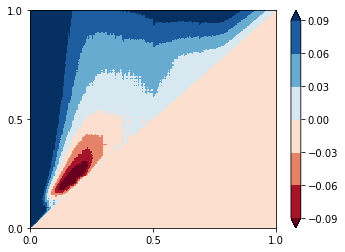

bipolar
RMSE:0.1577
MAE: 0.1061
bias:0.06919
max: 1.492
min: -1.109


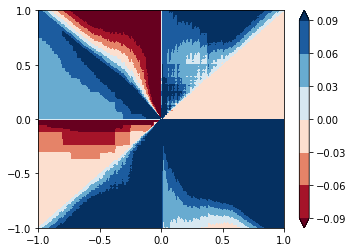

In [5]:
test(mode="unipolar", depth_abs=3, depth_kernel=2, depth_sync=2, shiftreg=False, rng="Sobol", rng_dim=4, bitwidth=8, total_cnt=100, savepdf=False)
test(mode="bipolar", depth_abs=3, depth_kernel=2, depth_sync=2, shiftreg=False, rng="Sobol", rng_dim=4, bitwidth=8, total_cnt=100, savepdf=False)

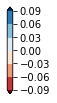

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(0.1, 1.6)
cmap = cm.RdBu
bounds = [-0.12, -0.09, -0.06, -0.03, 0.00, 0.03, 0.06, 0.09, 0.12]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                extend='both',
                                spacing='uniform',
                                orientation='vertical')

# plt.tight_layout()
# plt.savefig("colorbar.pdf", dpi=300, bbox_inches='tight')
plt.show()